In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plant-seedlings-classification/sample_submission.csv
/kaggle/input/plant-seedlings-classification/test/fd87b36ae.png
/kaggle/input/plant-seedlings-classification/test/0e8492cb1.png
/kaggle/input/plant-seedlings-classification/test/8d6acbe9b.png
/kaggle/input/plant-seedlings-classification/test/54b3afd58.png
/kaggle/input/plant-seedlings-classification/test/6049234e6.png
/kaggle/input/plant-seedlings-classification/test/82b5f4d33.png
/kaggle/input/plant-seedlings-classification/test/a0f37c726.png
/kaggle/input/plant-seedlings-classification/test/e0ec5b6a1.png
/kaggle/input/plant-seedlings-classification/test/1cfd91582.png
/kaggle/input/plant-seedlings-classification/test/456d507c0.png
/kaggle/input/plant-seedlings-classification/test/d6d31dcbe.png
/kaggle/input/plant-seedlings-classification/test/e1abb4ff9.png
/kaggle/input/plant-seedlings-classification/test/aa7d098d1.png
/kaggle/input/plant-seedlings-classification/test/e19673dc9.png
/kaggle/input/plant-seedlings-classif

In [2]:
!ls '/kaggle/input/plant-seedlings-classification/train'

 Black-grass	    'Common wheat'	'Scentless Mayweed'
 Charlock	    'Fat Hen'		'Shepherds Purse'
 Cleavers	    'Loose Silky-bent'	'Small-flowered Cranesbill'
'Common Chickweed'   Maize		'Sugar beet'


In [3]:
print(os.listdir("/kaggle/input/plant-seedlings-classification/train"))

['Scentless Mayweed', 'Common wheat', 'Charlock', 'Black-grass', 'Sugar beet', 'Loose Silky-bent', 'Maize', 'Cleavers', 'Common Chickweed', 'Fat Hen', 'Small-flowered Cranesbill', 'Shepherds Purse']


In [4]:
#Clases
clases=["Black-grass","Charlock","Cleavers","Common Chickweed","Common wheat","Fat Hen","Loose Silky-bent","Maize","Scentless Mayweed",
        "Shepherds Purse","Small-flowered Cranesbill","Sugar beet"]

In [5]:
#Creo un objeto ImageDataGenerator para la data de train y val
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generador=ImageDataGenerator(
    rescale=1/255,
    rotation_range=30, #30° de rotación
    fill_mode="nearest", #rellenar con los píxeles cercanos
    brightness_range=[0.5,1.5], #rango de 0.5 - 1.5 (iluminosidad de la img)
    zoom_range=0.2, #20% de zoom a la img
    validation_split=0.2 #El 20% será para validación
)

val_generador=ImageDataGenerator(
    rescale=1/255, #Solamente reescalo los valores de los píxeles
    validation_split=0.2
)

In [6]:
#Creo generadores a parte para la data de train y val
train_gen=train_generador.flow_from_directory(
    directory="/kaggle/input/plant-seedlings-classification/train",
    target_size=(224,224), #El tamaño de las imágenes
    subset="training", #Especifico "training", para indicar que corresponde a la data de train
    batch_size=20,
    class_mode="sparse", #Labels int
)
val_gen=val_generador.flow_from_directory(
    directory="/kaggle/input/plant-seedlings-classification/train",
    target_size=(224,224),
    subset="validation", #Validación
    batch_size=20,
    class_mode="sparse",
    shuffle=False #No es necesario hacer shuffle aquí, para que Keras no mezcle de nuevo aleatoriamente las imágenes

)

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


In [7]:
#Veo las clases, para saber si hay, o no, desbalance
import numpy as np
train_instancias=np.unique(train_gen.classes,return_counts=True)
val_instancias=np.unique(val_gen.classes,return_counts=True)

print(train_instancias[1])
print(val_instancias[1])

[211 312 230 489 177 380 524 177 413 185 397 308]
[ 52  78  57 122  44  95 130  44 103  46  99  77]


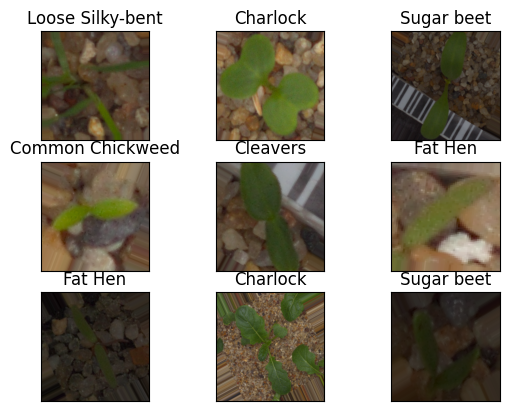

In [8]:
#Veo algunas imágenes
import matplotlib.pyplot as plt
for batch,label_batch in train_gen:
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(batch[i])
    plt.xticks([]),plt.yticks([])
    plt.title(clases[int(label_batch[i])])
  break

In [9]:
#Uso VGG16
from tensorflow.keras.applications import vgg16
VGG16=vgg16.VGG16(
    include_top=False, #Solamente obtengo la base convolucional
    input_shape=(224,224,3), #Shape de la data
    weights="imagenet" #Pesos del modelo entrenado en el dataset 'imagenet'
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
#Fine-tuning
VGG16.trainable=True

In [11]:
for layer in VGG16.layers[:-2]:
  layer.trainable=False #Solamente las últimas 2 capas se entrenarán

In [12]:
VGG16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 2,359,808 (9.00 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [13]:
#Añado algunas capas
from tensorflow import keras
from tensorflow.keras import layers
x=VGG16.output
x=layers.Flatten()(x)
x=layers.Dense(1024,activation="relu")(x)
x=layers.Dense(512,activation="relu")(x)
output=layers.Dense(12,activation="softmax")(x)
modelo=keras.Model(VGG16.inputs,output)

In [14]:
modelo.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      25,691,136 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 40,936,780 (156.16 MB)

 Trainable params: 28,581,900 (109.03 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [15]:
#Ajusto los callbacks
from tensorflow.keras import callbacks
ES=callbacks.EarlyStopping(
    monitor="val_loss", #métrica a monitorear
    patience=5, #épocas luego del mejor valor de la métrica monitoreada
    restore_best_weights=True #Se guardan los pesos del modelo con el mejor valor de la métrica
)

In [16]:
#Learning_rate --> Ajustar el valor
learning_rate=0.001 #Ajustando

In [17]:
#compile step
modelo.compile(
    optimizer="adam", #Esto ajustar
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [18]:
#Entrenando el modelo
history=modelo.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[ES]
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


191/191 ━━━━━━━━━━━━━━━━━━━━ 136s 618ms/step - accuracy: 0.2812 - loss: 2.4748 - val_accuracy: 0.5913 - val_loss: 1.1349
Epoch 2/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 85s 431ms/step - accuracy: 0.5472 - loss: 1.2501 - val_accuracy: 0.6800 - val_loss: 0.9350
Epoch 3/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 85s 430ms/step - accuracy: 0.6413 - loss: 0.9955 - val_accuracy: 0.6895 - val_loss: 0.8522
Epoch 4/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 85s 430ms/step - accuracy: 0.6874 - loss: 0.8515 - val_accuracy: 0.7064 - val_loss: 0.8594
Epoch 5/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 85s 431ms/step - accuracy: 0.7350 - loss: 0.7517 - val_accuracy: 0.7423 - val_loss: 0.7779
Epoch 6/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 85s 431ms/step - accuracy: 0.7644 - loss: 0.6375 - val_accuracy: 0.7423 - val_loss: 0.7344
Epoch 7/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 85s 432ms/step - accuracy: 0.7574 - loss: 0.6645 - val_accuracy: 0.7645 - val_loss: 0.6886
Epoch 8/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 86s 433ms/step - accuracy: 0.7977 - loss: 0.5927 - va

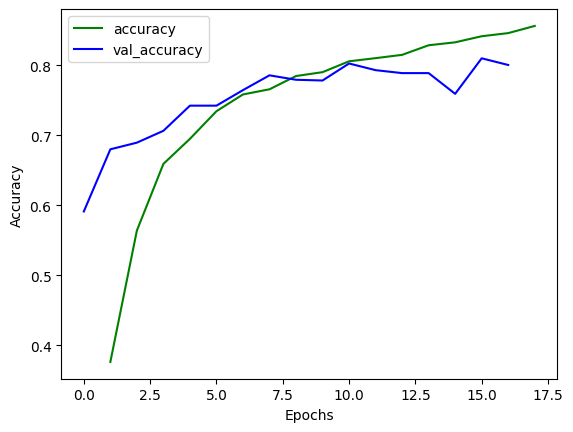

In [19]:
import matplotlib.pyplot as plt
accuracy=history.history["accuracy"]
val_accuracy=history.history["val_accuracy"]

plt.plot(range(1,len(accuracy)+1),accuracy,color="g",label="accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(val_accuracy,color="b",label="val_accuracy")
plt.legend()
plt.show()

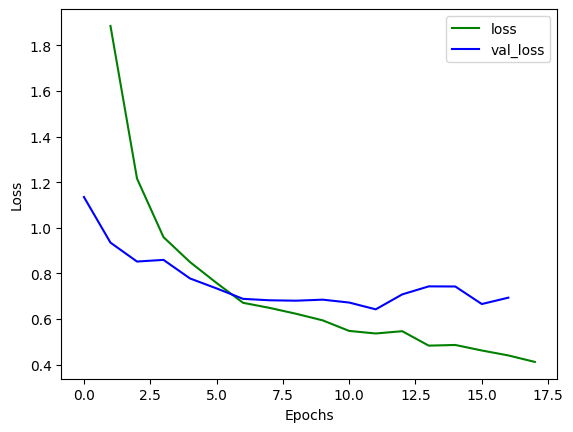

In [20]:
loss=history.history["loss"]
val_loss=history.history["val_loss"]

plt.plot(range(1,len(loss)+1),loss,color="g",label="loss")
plt.plot(val_loss,color="b",label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [21]:
#Almaceno los nombres de las imágenes en una lista
def load_test_image_paths(test_dir):
    image_paths = []
    
    for img_name in os.listdir(test_dir):
        img_path = os.path.join(test_dir, img_name)
        image_paths.append(img_path)
    
    np.random.shuffle(image_paths)
    
    return image_paths

In [22]:
#Cargo la data de test
import cv2

test_dir = '/kaggle/input/plant-seedlings-classification/test'
test_image_paths = load_test_image_paths(test_dir)

def normalize_data(image_paths):
    processed_images = []
    
    for img_path in image_paths:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))  #Resize de 224,224 a la imagen
        img = img / 255.0  # Normalización
        processed_images.append(img)
    
    return np.array(processed_images)

x_test=normalize_data(test_image_paths)

In [23]:
#Hago las predicciones
predicciones=modelo.predict(x_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 739ms/step


In [24]:
#Ahora, obtengo los índices con mayor valor de probabilidad, pues representa la clase a la que pertenece
pred=np.argmax(predicciones,axis=1)

In [25]:
#Ahora, esos valores de índices deben ser las clases, para ello uso la lista (convertida a array)
#que definí al inicio
clases_pred=np.array(clases)[pred]

In [26]:
#Creo el dataframe
resultados=pd.DataFrame({
    "file":[os.path.basename(path) for path in test_image_paths],
    "species":clases_pred
})

In [27]:
print(resultados.head())

            file            species
0  76dbd1054.png  Scentless Mayweed
1  aad8375e0.png    Shepherds Purse
2  74fd477eb.png   Common Chickweed
3  8e29abce1.png  Scentless Mayweed
4  1926e82fd.png   Loose Silky-bent


In [28]:
#Guardo los resultados
resultados.to_csv("resultados_model.csv",index=False)